In [1]:
import matplotlib.pyplot as plt
import numpy as np            
import pandas as pd        
import tensorflow as tf

from tensorflow import keras, math
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from sklearn.utils import resample
from vit_keras import vit

#Đường dẫn thư mục train và test
train_path = r'.\train'
test_path = r'.\test'
val_path = r'.\val'

batch_size = 32 

img_height = 224
img_width = 224

c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Data augmentation for training
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

# Data augmentation for testing/validation
test_data_gen = ImageDataGenerator(rescale=1./255)

In [3]:
# Training data generator
train_generator = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Testing data generator
test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='rgb', 
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# Validation data generator
validation_generator = image_gen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

Found 1943 images belonging to 2 classes.
Found 611 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [4]:
print(train_generator.class_indices)

{'1_Normal': 0, '2_Disease': 1}


In [10]:
# Load the Vision Transformer model
vit_model = vit.vit_b16(
    image_size=img_height,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=1
)

# Fine-tune more layers
for layer in vit_model.layers[:-10]:
    layer.trainable = False

# Compile the model with a different optimizer and learning rate
vit_model.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early = EarlyStopping(monitor="val_loss", mode="min", patience=8, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction, lr_scheduler]

# Compute class weights
from sklearn.utils.class_weight import compute_sample_weight

unique_classes = np.unique(train_generator.classes)
weights = compute_sample_weight(class_weight='balanced', y=train_generator.classes)
cw = dict(zip(unique_classes, weights))
print(cw)

# Train the model
history = vit_model.fit(
    train_generator,
    epochs=20,  # Increase the number of epochs
    validation_data=validation_generator,
    class_weight=cw,
    callbacks=callbacks_list
)

c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


{0: 1.763157894736842, 1: 1.763157894736842}
Epoch 1/20
61/61 [==============================] - 936s 15s/step - loss: 0.9788 - accuracy: 0.7283 - val_loss: 0.6508 - val_accuracy: 0.6600 - lr: 3.0000e-05
Epoch 2/20
61/61 [==============================] - 648s 11s/step - loss: 0.8495 - accuracy: 0.7586 - val_loss: 0.4924 - val_accuracy: 0.7545 - lr: 3.0000e-05
Epoch 3/20
61/61 [==============================] - 649s 11s/step - loss: 0.7853 - accuracy: 0.7813 - val_loss: 0.4812 - val_accuracy: 0.7646 - lr: 3.0000e-05
Epoch 4/20
61/61 [==============================] - 645s 11s/step - loss: 0.7786 - accuracy: 0.7771 - val_loss: 0.6298 - val_accuracy: 0.6338 - lr: 3.0000e-05
Epoch 5/20
61/61 [==============================] - 645s 11s/step - loss: 0.7530 - accuracy: 0.7988 - val_loss: 0.4807 - val_accuracy: 0.7465 - lr: 3.0000e-05
Epoch 6/20
61/61 [==============================] - 647s 11s/step - loss: 0.6969 - accuracy: 0.8075 - val_loss: 0.5415 - val_accuracy: 0.7143 - lr: 3.0000e-05
E

In [11]:
vit_model.save('VisionTransformer.h5')

c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test data
test_accu = vit_model.evaluate(test)
print('The testing accuracy is:', test_accu[1] * 100, '%')

# Predict the labels for the test data
y_pred = vit_model.predict(test)
y_pred = np.round(y_pred).astype(int)  # Chuyển đổi dự đoán thành nhãn nhị phân (0 hoặc 1)

# Get the true labels
y_true = test.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Compute classification report
class_report = classification_report(y_true, y_pred, target_names=['Normal', 'Disease'])
print('Classification Report:')
print(class_report)

# Extract Sensitivity, Specificity, and F1-Score from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = sensitivity  # Recall là tên khác của Sensitivity
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Sensitivity: {sensitivity * 100:.2f}%')
print(f'Specificity: {specificity * 100:.2f}%')
print(f'F1-Score: {f1_score:.2f}')

20/20 [==============================] - 80s 4s/step - loss: 0.3356 - accuracy: 0.8642
The testing accuracy is: 86.41571402549744 %
20/20 [==============================] - 81s 4s/step
Confusion Matrix:
[[169  28]
 [ 55 359]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.75      0.86      0.80       197
     Disease       0.93      0.87      0.90       414

    accuracy                           0.86       611
   macro avg       0.84      0.86      0.85       611
weighted avg       0.87      0.86      0.87       611

Sensitivity: 86.71%
Specificity: 85.79%
F1-Score: 0.90


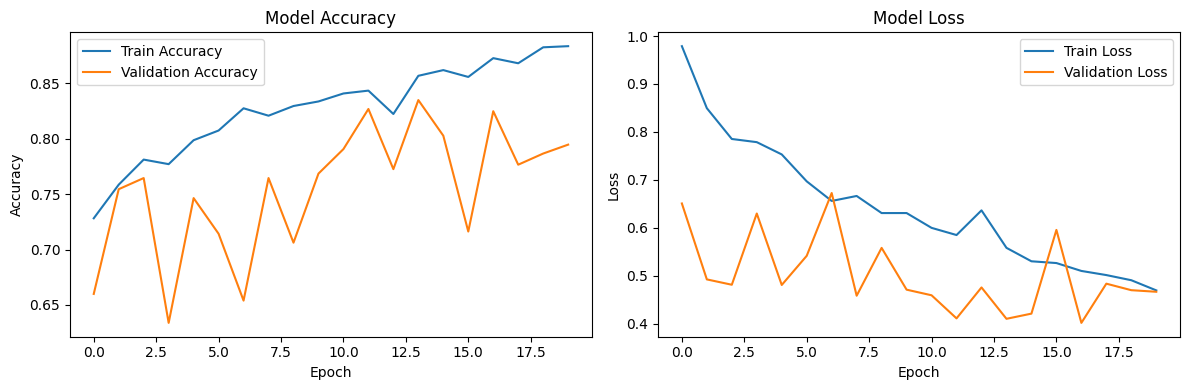

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()